# Project #2: Deduce the dependence of variability of AGN
See [Google Doc](https://docs.google.com/document/d/1yb43z7vrG5-FIL6lNZjVkIx41jKSCl698d51RQhXRqg/edit?tab=t.0) for more info.

This project is broken into the following steps:
1. Import Data
2. Crossmatch
3. Binning
4. Measure structure function
5. Visualize

This notebook assumes the user already has a local hatsified SDSS DR7 QSO catalog. 

This can be acquired using the included scripts `dl_sdss_dr7qso.sh` and `import_sdss_dr7sqo.py`, or obtained and converted from [this page](https://das.sdss.org/va/qso_properties_dr7/dr7.htm) on the SDSS website.

In [7]:
import hats
import lsdb
from hats.io.validation import is_valid_catalog

In [8]:
import tempfile
from dask.distributed import Client

# Need to create a tmp directory for dask workers to store their data that is NOT the user's home directory
#tmp_path = tempfile.TemporaryDirectory(dir="/data3/epyc/data3/hats/raw/sdss/")
#tmp_dir = tmp_path.name
#client = Client(n_workers=8, threads_per_worker=1, local_directory=tmp_dir)
#client

# Import Data

Select a large number of AGNs. Use SDSS AGN to start.  Find these AGNs in ZTF/PanSTARRS/Rubin ComCam data.

### Import SDSS (DR7QSO)

In [3]:
sdss_dir = "/data3/epyc/data3/hats/raw/sdss/sdss_dr7_qso_props/"
print("Valid catalog?", is_valid_catalog(sdss_dir))

Valid catalog? True


In [4]:
sdss = lsdb.read_hats(
    sdss_dir,
    columns=["RA", "DEC", "REDSHIFT", "SDSS_NAME", "LOGBH"]
)

In [5]:
sdss.head()

,RA,DEC,REDSHIFT,SDSS_NAME,LOGBH
_healpix_29,,,,,
1748843545125,45.075508,0.152306,2.2308,030018.12+000908.3,9.273159
2976627715402,44.884758,0.164801,0.8064,025932.34+000953.2,8.307456
5459300610667,45.18858,0.282409,1.7422,030045.25+001656.6,9.3182
5858887011909,45.339138,0.290646,0.4101,030121.39+001726.3,7.203714
7934686108383,45.189484,0.35918,1.4969,030045.47+002133.0,9.479626


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'SDSS DR7 QSO'}>)

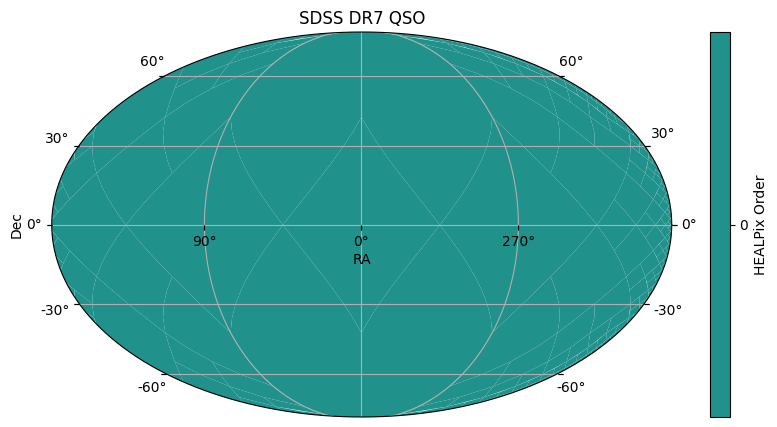

In [6]:
sdss.plot_pixels(plot_title="SDSS DR7 QSO")

### Import ZTF (w/ Margin Cache)

In [7]:
from lsdb import BoxSearch

#surveys_path = "https://data.lsdb.io/hats"
#ztf_object_path = f"{surveys_path}/ztf_dr14/ztf_object"
#ztf_margin_path = f"{surveys_path}/ztf_dr14/ztf_object_10arcs"

ztf_path = "/data3/epyc/data3/hats/catalogs/ztf_dr22/ztf_lc"
ztf_margin_path = "/data3/epyc/data3/hats/catalogs/ztf_dr22/ztf_lc_10arcs"

ztf = lsdb.read_hats(
    ztf_path, margin_cache=ztf_margin_path, columns=[
        "objectid", "objra", "objdec", "filterid", "nepochs", "hmjd", "mag", "magerr"
    ]
)
print(f"Margin size: {ztf.margin.hc_structure.catalog_info.margin_threshold} arcsec")

Margin size: 10.0 arcsec


In [8]:
ztf

,objectid,objra,objdec,filterid,nepochs,hmjd,mag,magerr
npartitions=10839,,,,,,,,
"Order: 4, Pixel: 0",int64[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int64[pyarrow],list<element: double>[pyarrow],list<element: float>[pyarrow],list<element: float>[pyarrow]
"Order: 4, Pixel: 1",...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...,...


In [9]:
ztf_path = "/data3/epyc/data3/hats/catalogs/ztf_dr22/ztf_lc"
ztf_margin_path = "/data3/epyc/data3/hats/catalogs/ztf_dr22/ztf_lc_10arcs"

ztf_hats = hats.read_hats(ztf_path)

In [10]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)

ztf_hats.aggregate_column_statistics()

,min_value,max_value,null_count
column_names,,,
objectid,202110100000000.0,1896211400028221.0,0.0
filterid,1.0,3.0,0.0
fieldid,202.0,1896.0,0.0
rcid,0.0,63.0,0.0
objra,0.0,360.0,0.0
objdec,-30.7,89.2,0.0
nepochs,1.0,1884.0,0.0
hmjd.list.element,58197.1,60491.4,0.0
mag.list.element,-2.5,32.4,0.0


#### Intermission to look into ZTF Lightcurves

In [11]:
# ztf_nested = ztf.nest_lists(
#     base_columns=[col for col in ztf.columns if col not in ["hmjd", "mag", "magerr"]],
#     name="lc",
# )

In [12]:
# ztf_nested.plot_pixels(plot_title="ztf_nested")

In [13]:
# ztf_mini = ztf_nested.cone_search(ra=-60.3, dec=20.5, radius_arcsec=1 * 600)
# ztf_mini

In [14]:
# ztf_mini.plot_pixels(plot_title="ztf_mini")

In [15]:
# tmp_path = tempfile.TemporaryDirectory(dir="/data3/epyc/data3/hats/raw/")
# tmp_dir = tmp_path.name
# with Client(n_workers=8, threads_per_worker=1, local_directory=tmp_dir) as client:
#     min_mjd = (
#         ztf_mini.reduce(
#             lambda mjd: {"min_mjd": mjd.min()},
#             "lc.hmjd",
#             meta={"min_mjd": float},
#         )["min_mjd"]
#         .min()
#         .compute()
#     )
# min_mjd

In [16]:
# #import light_curve as licu
# import matplotlib.pyplot as plt
# import numpy as np
# from dask.distributed import Client
# from lsdb import read_hats

In [17]:
# ZTF_ALERTS = "https://data.lsdb.io/hats/alerce/"

# # Load catalog with nested lists
# raw_catalog = read_hats(
#     ZTF_ALERTS,
# )
# display(raw_catalog)

# # Pack all list-columns into single column
# catalog_with_lc = raw_catalog.nest_lists(
#     base_columns=[col for col in raw_catalog.columns if not col.startswith("lc_")],
#     name="lc",
# )

# # Pack non-detections
# catalog_with_nondet = catalog_with_lc.nest_lists(
#     base_columns=[col for col in catalog_with_lc.columns if not col.startswith("nondet_")],
#     name="nondet",
# )

# # Pack ZTF references
# catalog = catalog_with_nondet.nest_lists(
#     base_columns=[col for col in catalog_with_nondet.columns if not col.startswith("ref_")],
#     name="ref",
# )

# catalog

In [18]:
# import matplotlib.pyplot as plt

# def plot_lightcurve(lc, filter_id, title=None):
#     """Plot light curve with non-detections."""
#     #for fid, band in zip([1, 2], "gr"): #TODO check what values are in "filterid" col
#     #    idx = lc["filterid"] == fid
#         # plt.scatter(lc["hmjd"][idx], lc["mag"][idx], label=band, color=band, marker="x", s=10)
#         # plt.errorbar(lc["lhmjd"][idx], lc["mag"][idx], lc["magerr"][idx], color=band, ls="")
#     bands = {
#         1: "g",
#         2: "r",
#         3: "i"
#     }
#     colors = {
#         1: "g",
#         2: "r",
#         3: "y"
#     }

#     plt.scatter(lc["hmjd"], lc["mag"], label=bands[filter_id], color=colors[filter_id], marker="x", s=10)
#     plt.errorbar(lc["hmjd"], lc["mag"], lc["magerr"], color=colors[filter_id], ls="")

#     plt.legend()
#     plt.title(title)
#     plt.xlabel("HMJD")
#     plt.ylabel("mag")
#     plt.gca().invert_yaxis()

In [19]:
# "Compute" the first partition and plot few light curves

# Single partition would require single worker
# with Client(n_workers=1, threads_per_worker=1, local_directory=tmp_dir) as client:
#     display(client)
#     ndf = ztf_mini.partitions[0].compute()

In [20]:
# for i in range(2):
#     lc = ndf["lc"].iloc[i]
#     object_id = ndf["objectid"].iloc[i]
#     filter_id = ndf["filterid"].iloc[i]
#     plt.figure()
#     plot_lc(lc, filter_id, title=object_id)

# Crossmatch

In [21]:
ztf

,objectid,objra,objdec,filterid,nepochs,hmjd,mag,magerr
npartitions=10839,,,,,,,,
"Order: 4, Pixel: 0",int64[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int64[pyarrow],list<element: double>[pyarrow],list<element: float>[pyarrow],list<element: float>[pyarrow]
"Order: 4, Pixel: 1",...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...,...


In [22]:
sdss

,RA,DEC,REDSHIFT,SDSS_NAME,LOGBH
npartitions=12,,,,,
"Order: 0, Pixel: 0",double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow]
"Order: 0, Pixel: 1",...,...,...,...,...
...,...,...,...,...,...
"Order: 0, Pixel: 10",...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...


In [23]:
sdss_x_ztf = sdss.crossmatch(ztf, n_neighbors=1, radius_arcsec=3, suffixes=["_sdss", "_ztf"])

In [24]:
sdss_x_ztf

,RA_sdss,DEC_sdss,REDSHIFT_sdss,SDSS_NAME_sdss,LOGBH_sdss,objectid_ztf,objra_ztf,objdec_ztf,filterid_ztf,nepochs_ztf,hmjd_ztf,mag_ztf,magerr_ztf,_dist_arcsec
npartitions=2760,,,,,,,,,,,,,,
"Order: 4, Pixel: 0",double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int64[pyarrow],list<element: double>[pyarrow],list<element: float>[pyarrow],list<element: float>[pyarrow],double[pyarrow]
"Order: 4, Pixel: 1",...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12282",...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...,...,...,...,...,...,...,...


(<Figure size 1000x500 with 2 Axes>, <WCSAxes: title={'center': 'SDSS x ZTF'}>)

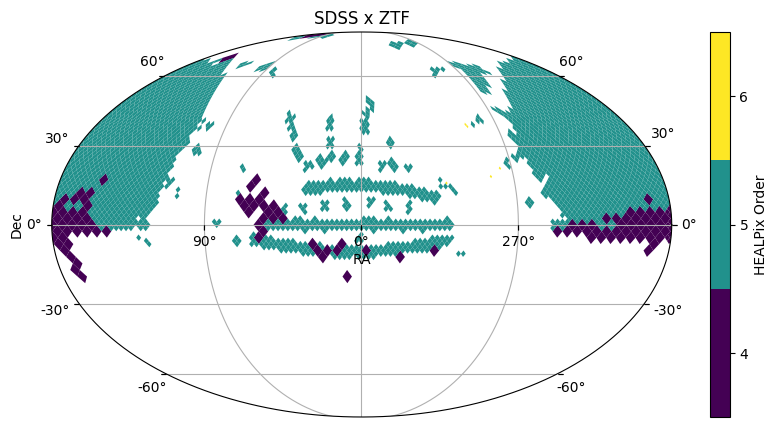

In [25]:
sdss_x_ztf.plot_pixels(plot_title="SDSS x ZTF")

In [27]:
# "Compute" the first partition and plot few light curves

# Single partition would require single worker
tmp_path = tempfile.TemporaryDirectory(dir="/data3/epyc/data3/hats/raw/sdss/")
tmp_dir = tmp_path.name
with Client(n_workers=16, threads_per_worker=1, local_directory=tmp_dir, memory_limit="20GB") as client:
    display(client)
    ndf = sdss_x_ztf.partitions[0].compute()

/astro/users/olynn/.conda/envs/p311/lib/python3.11/site-packages/distributed/node.py:173: ResourceWarning: unclosed <socket.socket fd=69, family=2, type=1, proto=6, laddr=('0.0.0.0', 0)>
  if retries_left < 1:
/astro/users/olynn/.conda/envs/p311/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44025 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44025/status,
Dashboard: http://127.0.0.1:44025/status,Workers: 16
Total threads: 16,Total memory: 298.02 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33495,Workers: 16
Dashboard: http://127.0.0.1:44025/status,Total threads: 16
Started: Just now,Total memory: 298.02 GiB
Comm: tcp://127.0.0.1:34022,Total threads: 1
Dashboard: http://127.0.0.1:35841/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:41916,


In [28]:
ndf

,RA_sdss,DEC_sdss,REDSHIFT_sdss,SDSS_NAME_sdss,LOGBH_sdss,objectid_ztf,objra_ztf,objdec_ztf,filterid_ztf,nepochs_ztf,hmjd_ztf,mag_ztf,magerr_ztf,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,
1748843545125,45.1,0.2,2.2,030018.12+000908.3,9.3,402314400000703,45.1,0.2,3,26,[59211.19299 59220.18693 59232.24832 59253.137...,[19.919155 20.330544 20.478958 20.249365 20.09...,[0.16309905 0.19148526 0.19479676 0.18755566 0...,0.1
2976627715402,44.9,0.2,0.8,025932.34+000953.2,8.3,402214400015996,44.9,0.2,2,170,[58345.47684 58346.45576 58347.4427 58348.459...,[20.479105 21.008183 20.898762 20.825438 20.69...,[0.1734622 0.21954441 0.2100594 0.20370328 0...,0.1
5459300610667,45.2,0.3,1.7,030045.25+001656.6,9.3,402214100007624,45.2,0.3,2,397,[58319.46343 58323.48325 58330.41979 58336.462...,[18.99347 19.013866 18.882828 19.041561 19.08...,[0.06750444 0.06855152 0.06210198 0.06999939 0...,0.1
5858887011909,45.3,0.3,0.4,030121.39+001726.3,7.2,1447207200009528,45.3,0.3,2,58,[58356.39091 58386.38343 58423.37972 58424.296...,[19.812162 19.676159 19.867046 19.709583 19.71...,[0.12427196 0.11277227 0.12912114 0.11552699 0...,0.1
7934686108383,45.2,0.4,1.5,030045.47+002133.0,9.5,402314100005023,45.2,0.4,3,66,[59184.33481 59187.27468 59200.28726 59203.257...,[19.072502 19.226034 19.1189 19.187363 19.26...,[0.10053448 0.11244124 0.10403369 0.1093551 0...,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183364305466072,44.0,1.2,1.9,025611.12+011234.9,9.4,1447212400004328,44.0,1.2,2,26,[58423.37976 58425.30813 58429.32808 58432.318...,[20.811016 20.516762 20.660496 20.837013 20.35...,[0.21611822 0.19033718 0.20293033 0.21839595 0...,0.0
183446950535900,44.0,1.2,1.0,025610.91+011324.3,8.0,1447112400002514,44.0,1.2,1,27,[58384.36184 58430.31485 58726.50292 58734.481...,[20.599236 20.843351 20.969254 21.203972 20.99...,[0.1637435 0.18248117 0.19214511 0.21016145 0...,0.2
186480513263349,43.8,1.2,2.8,025516.88+011134.3,9.3,1447112300002877,43.8,1.2,1,55,[58384.36186 58427.33335 58430.31485 58436.247...,[19.531242 19.343212 19.497196 19.407978 19.38...,[0.08546226 0.07456639 0.08339607 0.078177 0...,0.1


In [31]:
ndf.to_pickle("/astro/users/olynn/sdss_x_ztf_partition_0.pkl")

In [2]:
# Checkpoint: start here to avoid dask

import pandas as pd

ndf = pd.read_pickle("/astro/users/olynn/sdss_x_ztf_partition_0.pkl")

In [3]:
import matplotlib.pyplot as plt

def plot_lightcurve(row, title=None):
    """Plot light curve."""
    bands = {
        1: "g",
        2: "r",
        3: "i"
    }
    colors = {
        1: "green",
        2: "red",
        3: "goldenrod"
    }

    band=bands[row["filterid_ztf"]]
    color=colors[row["filterid_ztf"]]

    plt.scatter(row["hmjd_ztf"], row["mag_ztf"], label=band, color=color, marker="x", s=10)
    plt.errorbar(row["hmjd_ztf"], row["mag_ztf"], row["magerr_ztf"], color=color, ls="")

    plt.legend()
    plt.title(title)
    plt.xlabel("HMJD")
    plt.ylabel("mag")
    plt.gca().invert_yaxis()

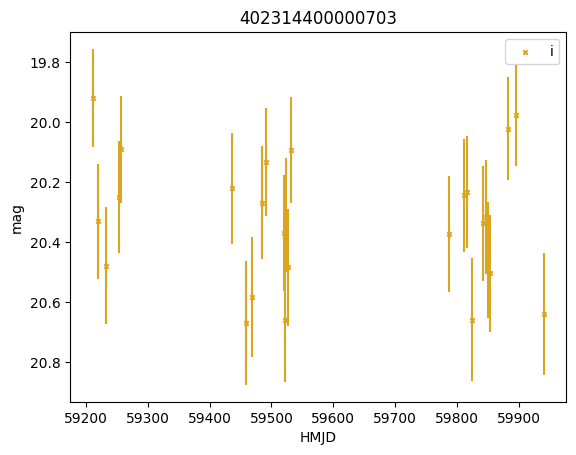

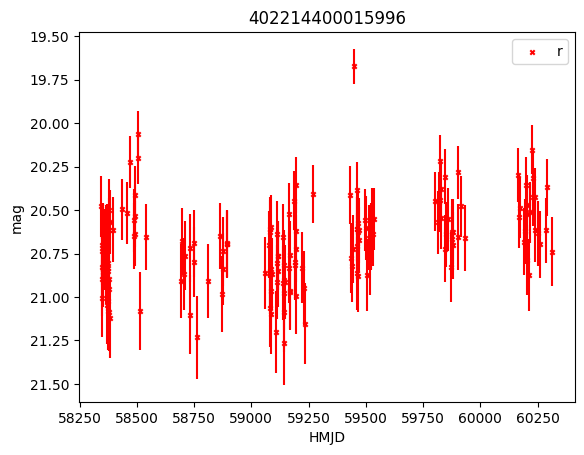

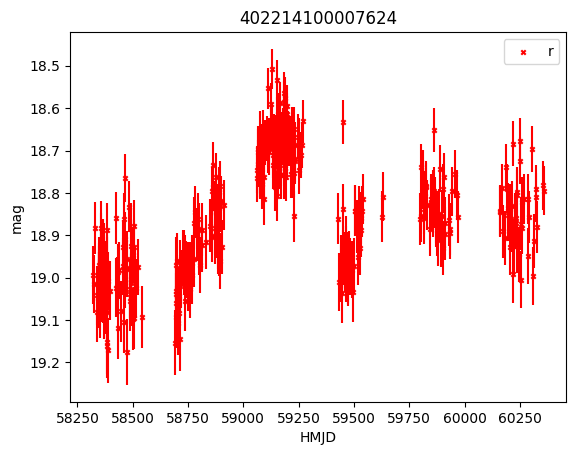

In [4]:
for i in range(3):
    row = ndf.iloc[i]
    object_id = ndf["objectid_ztf"].iloc[i]
    plt.figure()
    plot_lightcurve(row, title=object_id)

# Binning

Instructions:
> Split the sample in mass and redshift (several bins in redshift and several bins in mass). For instance see [Figure 4](https://s3.amazonaws.com/aasie/images/0004-637X/834/2/111/apjaa4d0bf4_hr.jpg) in [Neven's paper](https://ui.adsabs.harvard.edu/abs/2017ApJ...834..111C/graphics).

**Question: Do we have mass? What kind?**

**Answer: Yes--**  
From [the SDSS paper](https://iopscience.iop.org/article/10.1088/0067-0049/194/2/45):
> We also compile virial black hole mass estimates based on various calibrations. For the fiducial virial mass estimates we use the Vestergaard & Peterson (VP06) calibrations for Hβ and C iv, and our own calibration for Mg ii which matches the VP06 Hβ masses on average.  
> ...  
> 139...	DOUBLE	The adopted fiducial virial BH mass [log (MBH, vir/M☉)]  
> 140...	DOUBLE	Uncertainty in the fiducial virial BH mass (measurement uncertainty only)  

From the [SDSS DR7 QSO (SM) page](https://das.sdss.org/va/qso_properties_dr7/dr7.htm):
> 139	**LOGBH**	DOUBLE	The adopted fiducial virial BH mass (Msun)  
> 140	**LOGBH_ERR**	DOUBLE	Measurement error in LOGBH

**Question: What's the best practice for binning these?**  
Do I just add another column with "z_bin", etc? (Adding cols via [assign](https://docs.lsdb.io/en/stable/autoapi/lsdb/catalog/index.html#lsdb.catalog.Catalog.assign)?)

**Answer: No best practice known!**

## Let's start by looking at the column stats

In [5]:
#sdss_hats = hats.read_hats(sdss_dir)
#sdss_hats.aggregate_column_statistics(include_columns=["RA", "DEC", "REDSHIFT", "LOGBH", "LOGBH_ERR"])

It looks like 6 redshift bins (<1, 1-2, 2-3, 3-4, 4-5, >5) would be a good place to start.  
Similarly, we could try 6 mass (logbh) bins (<2, 2-4, 4-6, 6-8, 8-10, >10).  
Let's take a quick peak at the distribution in the first partition of 81 rows: 

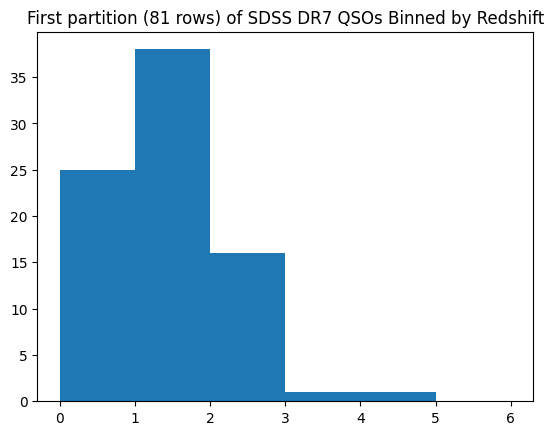

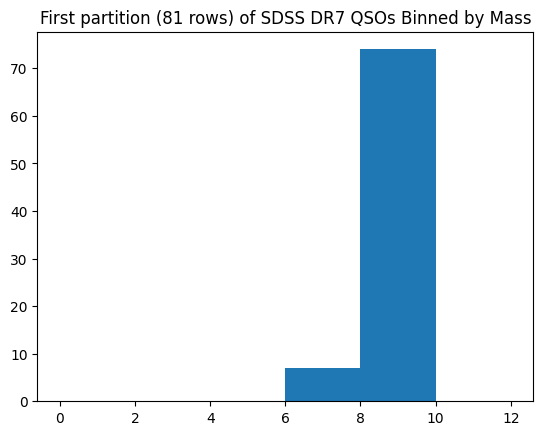

In [6]:
import numpy as np
import matplotlib.pyplot as plt

sdss_x_ztf_df = ndf

redshifts = np.array(sdss_x_ztf_df["REDSHIFT_sdss"])
masses = np.array(sdss_x_ztf_df["LOGBH_sdss"])

plt.hist(redshifts, bins=np.linspace(0.0, 6.0, 7))
plt.title("First partition (81 rows) of SDSS DR7 QSOs Binned by Redshift")
plt.show()
plt.hist(masses, bins=np.linspace(0.0, 12.0, 7))
plt.title("First partition (81 rows) of SDSS DR7 QSOs Binned by Mass")
plt.show()

Tbh, they seem more skewed than I'd prefer.  
But, this is only the first few of 105,000+ rows, so let's go ahead with this for now, and we can come back later if we want.

In [7]:
def bin_redshift(val):
    return val.astype(int)
def bin_mass(val):
    return (val*0.5).astype(int)

#sdss_x_ztf = sdss_x_ztf.assign(redshift_bin=lambda x: bin_redshift(x['REDSHIFT_sdss']))
#sdss_x_ztf = sdss_x_ztf.assign(mass_bin=lambda x: bin_mass(x['LOGBH_sdss']))

sdss_x_ztf_df = sdss_x_ztf_df.assign(redshift_bin=lambda x: bin_redshift(x['REDSHIFT_sdss']))
sdss_x_ztf_df = sdss_x_ztf_df.assign(mass_bin=lambda x: bin_mass(x['LOGBH_sdss']))

In [8]:
sdss_x_ztf_df.head()

,RA_sdss,DEC_sdss,REDSHIFT_sdss,SDSS_NAME_sdss,LOGBH_sdss,objectid_ztf,objra_ztf,objdec_ztf,filterid_ztf,nepochs_ztf,hmjd_ztf,mag_ztf,magerr_ztf,_dist_arcsec,redshift_bin,mass_bin
_healpix_29,,,,,,,,,,,,,,,,
1748843545125,45.075508,0.152306,2.2308,030018.12+000908.3,9.273159,402314400000703,45.075535,0.152292,3,26,[59211.19299 59220.18693 59232.24832 59253.137...,[19.919155 20.330544 20.478958 20.249365 20.09...,[0.16309905 0.19148526 0.19479676 0.18755566 0...,0.10548,2,4
2976627715402,44.884758,0.164801,0.8064,025932.34+000953.2,8.307456,402214400015996,44.884762,0.164826,2,170,[58345.47684 58346.45576 58347.4427 58348.459...,[20.479105 21.008183 20.898762 20.825438 20.69...,[0.1734622 0.21954441 0.2100594 0.20370328 0...,0.092813,0,4
5459300610667,45.18858,0.282409,1.7422,030045.25+001656.6,9.3182,402214100007624,45.188557,0.282438,2,397,[58319.46343 58323.48325 58330.41979 58336.462...,[18.99347 19.013866 18.882828 19.041561 19.08...,[0.06750444 0.06855152 0.06210198 0.06999939 0...,0.134617,1,4
5858887011909,45.339138,0.290646,0.4101,030121.39+001726.3,7.203714,1447207200009528,45.339123,0.290644,2,58,[58356.39091 58386.38343 58423.37972 58424.296...,[19.812162 19.676159 19.867046 19.709583 19.71...,[0.12427196 0.11277227 0.12912114 0.11552699 0...,0.050533,0,3
7934686108383,45.189484,0.35918,1.4969,030045.47+002133.0,9.479626,402314100005023,45.189465,0.359199,3,66,[59184.33481 59187.27468 59200.28726 59203.257...,[19.072502 19.226034 19.1189 19.187363 19.26...,[0.10053448 0.11244124 0.10403369 0.1093551 0...,0.090226,1,4


---

# Measure structure function for these subsamples
Instructions:
> Measure structure function for these subsamples. Decide by yourself how you will measure structure function (i.e., make the function from scratch, use implementation shown on the Internet, etc…).

In [9]:
import numpy as np


class LightCurve:
    """This base class is meant to support various analysis routines and be
    extended as needed. (Hence it's location in the `analysis` package.)

    The base class ensures that the data for a single lightcurve is well formed.
    Namely that the input data is all of the same length, with NaN's removed and
    that there are enough observations to perform a given analysis.
    """

    def __init__(
        self, times: np.ndarray, fluxes: np.ndarray, errors: np.ndarray, minimum_observations: int = 0
    ):
        """Calls the processing functions to clean and validate the input data.
        All of the input arrays should have the same length.

        Parameters
        ----------
        times : np.ndarray
            The timestamps values of the data.
        fluxes : np.ndarray
            The flux/magnitude values of the data.
        errors : np.ndarray
            The error in the measurements.
        minimum_observations : int, optional
            The minimum number of data points needed to successfully process
            the lightcurve, by default 0
        """
        # The primary data
        self._times = times
        self._fluxes = fluxes
        self._errors = errors
        self._minimum_observations = minimum_observations

        self._process_input_data()

    def _process_input_data(self):
        """Cleaning and validation occurs here, ideally by calling
        sub-methods for specific checks and cleaning tasks.
        """
        self._check_input_data_size_is_equal()  # make sure arrays the same length
        self._filter_nans()
        self._check_input_data_length_is_sufficient()  # make sure we have enough values still

    def _filter_nans(self):
        """Mask out any NaN values from time, flux and error arrays"""

        t_mask = np.isnan(self._times)
        f_mask = np.isnan(self._fluxes)
        e_mask = np.isnan(self._errors)

        # np.logical_or takes at most 2 arguments, using reduce will collapse
        # the first two arguments into one, and apply it to the third.
        nan_mask = np.logical_or.reduce((t_mask, f_mask, e_mask))

        self._times = self._times[~nan_mask]
        self._fluxes = self._fluxes[~nan_mask]
        self._errors = self._errors[~nan_mask]

    def _check_input_data_size_is_equal(self):
        """Make sure that the three input np.arrays have the same size"""
        if self._times.size != self._fluxes.size or self._times.size != self._errors.size:
            raise ValueError("Input np.arrays are expected to have the same size.")

    def _check_input_data_length_is_sufficient(self):
        """Make sure that we have enough data after cleaning and filtering
        to be able to perform Structure Function calculations.
        """
        if self._times.size < self._minimum_observations:
            raise ValueError("Too few observations provided to create `LightCurve`.")

In [10]:
# Copying code from tape at: https://github.com/lincc-frameworks/tape/blob/main/src/tape/analysis/structure_function/sf_light_curve.py

from typing import Optional
import numpy as np

#from tape.analysis.light_curve import LightCurve

MIN_OBSERVATIONS_REQUIRED_FOR_SF = 3


class StructureFunctionLightCurve(LightCurve):
    def __init__(self, times: np.ndarray, fluxes: np.ndarray, errors: np.ndarray):
        super().__init__(times, fluxes, errors, MIN_OBSERVATIONS_REQUIRED_FOR_SF)

        # The derived data from the primary data
        self._all_d_times: np.array = []
        self._all_d_fluxes: np.array = []
        self._all_sum_squared_error: np.array = []

        # _public_ derived data
        self.sample_d_times: np.array = []
        self.sample_d_fluxes: np.array = []
        self.sample_sum_squared_error: np.array = []

        self.number_of_difference_values = None

        self._calculate_differences()

    def _calculate_differences(self):
        """Calculate the difference between all possible pairs of time and flux.
        Also calculate the sum of all possible pairs of error^2. To avoid
        duplicate values, we filter out any differences that correspond to a
        time difference less than 0.
        """
        dt_matrix = self._times.reshape((1, self._times.size)) - self._times.reshape((self._times.size, 1))
        self._all_d_times = dt_matrix[dt_matrix > 0].flatten()
        self.sample_d_times = self._all_d_times
        self.number_of_difference_values = self._all_d_times.size

        df_matrix = self._fluxes.reshape((1, self._fluxes.size)) - self._fluxes.reshape(
            (self._fluxes.size, 1)
        )
        self._all_d_fluxes = df_matrix[dt_matrix > 0].flatten()
        self.sample_d_fluxes = self._all_d_fluxes

        err2_matrix = (
            self._errors.reshape((1, self._errors.size)) ** 2
            + self._errors.reshape((self._errors.size, 1)) ** 2
        )
        self._all_sum_squared_error = err2_matrix[dt_matrix > 0].flatten()
        self.sample_sum_squared_error = self._all_sum_squared_error

    def select_difference_samples(
        self, number_of_samples: Optional[int] = None, random_generator: Optional[np.random.Generator] = None
    ):
        """Take a random sample of time and flux differences and the sum of squared
        errors. The samples are selected without replacement. The resulting
        sub-sample is not guaranteed to have the same order as the input
        differences.

        Parameters
        ----------
        number_of_samples : int, optional
            Defines the number of samples to be randomly selected from the total
            number of difference values. If not specified, take all of the
            avaliable values
        random_generator: np.random.Generator, optional
            A Numpy random.Generator to sample the lightcurve difference. This
            allows for repeatable random samples to be selected. By default None.

        Raises
        ------
        ValueError
            If samples are requested than are present in the light curve raise
            ValueError.

        """

        if number_of_samples is None:
            number_of_samples = self.number_of_difference_values

        if number_of_samples > self.number_of_difference_values:
            raise ValueError(
                f"Requesting {number_of_samples} samples, but only "
                f"{self.number_of_difference_values} are present in the lightcurve"
            )

        # Initialize a random generator if one was not provided
        if random_generator is None:
            random_generator = np.random.default_rng()

        # Stack the time and flux differences and errors.
        data_block = np.vstack((self._all_d_times, self._all_d_fluxes, self._all_sum_squared_error)).astype(
            float
        )

        # Randomly choose `number_of_samples` from the data_block. Return the
        # random samples into distinct arrays.
        self.sample_d_times, self.sample_d_fluxes, self.sample_sum_squared_error = random_generator.choice(
            data_block, number_of_samples, replace=True, axis=1, shuffle=False
        )

In [11]:
# From TDAstro:

import numpy.typing as npt
def mag2flux(mag: npt.ArrayLike) -> npt.ArrayLike:
    """Convert AB magnitude to bandflux in nJy

    Parameters
    ----------
    mag : ndarray of float
        The magnitude to convert to bandflux.

    Returns
    -------
    bandflux : ndarray of float
        The bandflux corresponding to the input magnitude.
    """
    # AB definition is zp=8.9 for 1 Jy
    MAG_AB_ZP_NJY = 8.9 + 2.5 * 9
    return np.power(10.0, -0.4 * (mag - MAG_AB_ZP_NJY))

In [19]:
subset = sdss_x_ztf_df.head(10)
subset

,RA_sdss,DEC_sdss,REDSHIFT_sdss,SDSS_NAME_sdss,LOGBH_sdss,objectid_ztf,objra_ztf,objdec_ztf,filterid_ztf,nepochs_ztf,hmjd_ztf,mag_ztf,magerr_ztf,_dist_arcsec,redshift_bin,mass_bin
_healpix_29,,,,,,,,,,,,,,,,
1748843545125,45.075508,0.152306,2.2308,030018.12+000908.3,9.273159,402314400000703,45.075535,0.152292,3,26,[59211.19299 59220.18693 59232.24832 59253.137...,[19.919155 20.330544 20.478958 20.249365 20.09...,[0.16309905 0.19148526 0.19479676 0.18755566 0...,0.10548,2,4
2976627715402,44.884758,0.164801,0.8064,025932.34+000953.2,8.307456,402214400015996,44.884762,0.164826,2,170,[58345.47684 58346.45576 58347.4427 58348.459...,[20.479105 21.008183 20.898762 20.825438 20.69...,[0.1734622 0.21954441 0.2100594 0.20370328 0...,0.092813,0,4
5459300610667,45.18858,0.282409,1.7422,030045.25+001656.6,9.3182,402214100007624,45.188557,0.282438,2,397,[58319.46343 58323.48325 58330.41979 58336.462...,[18.99347 19.013866 18.882828 19.041561 19.08...,[0.06750444 0.06855152 0.06210198 0.06999939 0...,0.134617,1,4
5858887011909,45.339138,0.290646,0.4101,030121.39+001726.3,7.203714,1447207200009528,45.339123,0.290644,2,58,[58356.39091 58386.38343 58423.37972 58424.296...,[19.812162 19.676159 19.867046 19.709583 19.71...,[0.12427196 0.11277227 0.12912114 0.11552699 0...,0.050533,0,3
7934686108383,45.189484,0.35918,1.4969,030045.47+002133.0,9.479626,402314100005023,45.189465,0.359199,3,66,[59184.33481 59187.27468 59200.28726 59203.257...,[19.072502 19.226034 19.1189 19.187363 19.26...,[0.10053448 0.11244124 0.10403369 0.1093551 0...,0.090226,1,4
10728514697650,44.91671,0.310625,1.8511,025940.01+001838.2,9.538599,402214100007307,44.916683,0.310635,2,173,[58336.46225 58340.45918 58343.50132 58345.476...,[20.665348 20.432995 20.902079 21.03757 20.65...,[0.20110369 0.18052655 0.22202396 0.23399758 0...,0.098435,1,4
11393244079747,44.799366,0.303562,2.8464,025911.84+001812.8,8.647228,402314200011538,44.799351,0.303588,3,58,[59184.33479 59190.26198 59200.28723 59203.257...,[19.42474 19.754389 19.434067 19.24149 19.72...,[0.12937462 0.15835318 0.13017844 0.11407036 0...,0.11502,2,4
14563096122717,45.079533,0.439641,1.5338,030019.08+002622.7,8.77905,402214100005997,45.079521,0.439643,2,316,[58319.46343 58323.48325 58336.46223 58343.501...,[19.83517 19.933748 20.091545 19.996326 19.74...,[0.12531628 0.13400766 0.14851701 0.1396861 0...,0.036731,1,4
17571969709560,44.991077,0.581738,0.8199,025957.85+003454.2,8.902016,1447107200000986,44.991074,0.581741,1,58,[58384.36177 58427.33332 58430.31483 58436.247...,[19.054705 19.12526 19.115528 19.232697 19.05...,[0.05932239 0.06258167 0.06212179 0.06788252 0...,0.019145,0,4


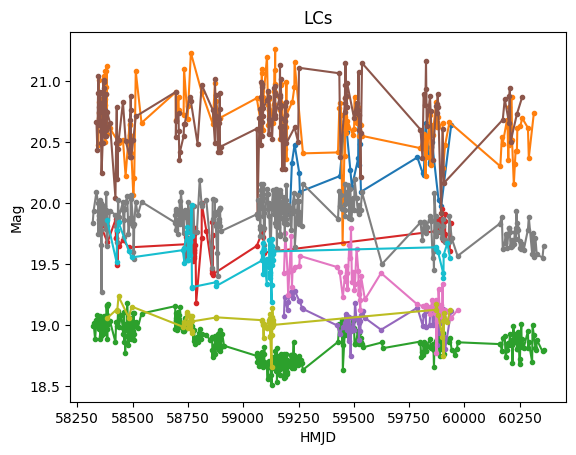

In [20]:
plt.figure()

for row in subset.itertuples():
    plt.plot(
        row[11],
        row[12],
        marker=".",
    )
    
plt.title("LCs")
plt.xlabel("HMJD")
plt.ylabel("Mag")
plt.show()

In [16]:
#sflc0 = StructureFunctionLightCurve(times, fluxes, errors)
# I asked and Neven likes macleod_2012

In [26]:
results = []
for i in range(len(subset)):
    times = np.array(subset["hmjd_ztf"])[i]
    mags = np.array(subset["mag_ztf"])[i]
    errors_mag = np.array(subset["magerr_ztf"])[i]
    fluxes = mag2flux(mags)
    errors = mag2flux(errors_mag)
    results.append(calc_sf2(times, fluxes, errors, sf_method="macleod_2012"))

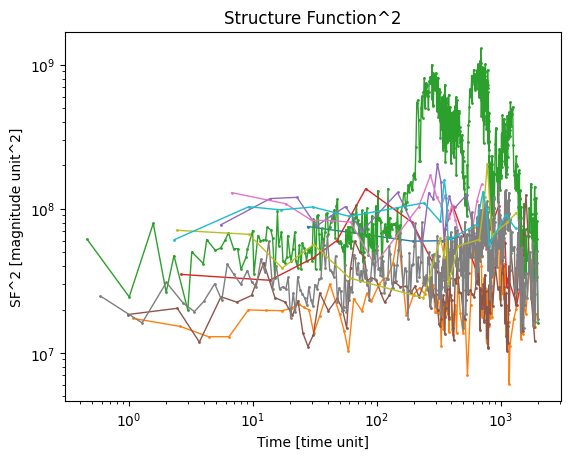

In [35]:
plt.figure()

for res in results:
    plt.plot(
            res["dt"],
            res["sf2"],
            marker=".",
            linewidth=1,
            markersize=2
        )

plt.yscale("log")
plt.xscale("log")
plt.title("Structure Function^2")
plt.xlabel("Time [time unit]")
plt.ylabel("SF^2 [magnitude unit^2]")
plt.show()


In [22]:
from typing import Dict, List

import numpy as np
import pandas as pd

from tape.analysis.base import AnalysisFunction
from tape.analysis.structure_function import SF_METHODS
from tape.analysis.structure_function.sf_light_curve import StructureFunctionLightCurve


__all__ = ["StructureFunction2", "calc_sf2"]


class StructureFunction2(AnalysisFunction):
    """Calculate structure function squared"""

    def cols(self, ens: "Ensemble") -> List[str]:
        return [
            ens._time_col,
            ens._flux_col,
            ens._err_col,
            ens._band_col,
            ens._id_col,
        ]

    def meta(self, ens: "Ensemble") -> Dict[str, type]:
        return {"lc_id": int, "band": str, "dt": float, "sf2": float, "1_sigma": float}

    def on(self, ens: "Ensemble") -> List[str]:
        return [ens._id_col]

    def __call__(
        self, time, flux, err=None, band=None, lc_id=None, *, sf_method="basic", argument_container=None
    ) -> pd.DataFrame:
        """Calculate structure function squared using one of a variety of structure
        function calculation methods defined by the input argument `sf_method`, or
        in the argument container object.


        Parameters
        ----------
        time : `numpy.ndarray` (N,) or `None`
            Array of times when measurements were taken. If all array values are
            `None` or if a scalar `None` is provided, then equidistant time between
            measurements is assumed.
        flux : `numpy.ndarray` (N,)
            Array of flux/magnitude measurements.
        err : `numpy.ndarray` (N,), `float`, or `None`, optional
            Array of associated flux/magnitude errors. If a scalar value is provided
            we assume that error for all measurements. If `None` is provided, we
            assume all errors are 0. By default None
        band : `numpy.ndarray` (N,), optional
            Array of associated band labels, by default None
        lc_id : `numpy.ndarray` (N,), optional
            Array of lightcurve ids per data point. By default None
        sf_method : str, optional
            The structure function calculation method to be used, by default "basic".
        argument_container : StructureFunctionArgumentContainer, optional
            Container object for additional configuration options, by default None.

        Returns
        -------
        sf2 : `pandas.DataFrame`
            Structure function squared for each of input bands.

        Notes
        ----------
        In case that no value for `band_to_calc` is passed, the function is
        executed on all available bands in `band`.
        """

        argument_container = _create_arg_container_if_needed(sf_method, argument_container)

        band = _validate_band(band, flux, argument_container)

        lc_id = _validate_lightcurve_id(lc_id, flux, argument_container)

        sf_method = _validate_sf_method(sf_method, argument_container)

        _validate_argument_container(argument_container)

        unq_band = np.unique(band)
        unq_ids = np.unique(lc_id)

        band_to_calc = argument_container.band_to_calc
        if band_to_calc is None:
            band_to_calc = unq_band
        if isinstance(band_to_calc, str):
            band_to_calc = [band_to_calc]

        assert hasattr(band_to_calc, "__iter__") is True

        ids = []
        dts = []
        bands = []
        sf2s = []
        sf2_err = []
        sf2_lower_error = []
        sf2_upper_error = []
        for b in band_to_calc:
            if b in unq_band:
                band_mask = band == b

                # Mask on band
                times = _extract_time(time=time, band_mask=band_mask, argument_container=argument_container)

                errors = _extract_error(err=err, band_mask=band_mask)

                fluxes = np.array(flux)[band_mask]
                lc_ids = np.array(lc_id)[band_mask]

                # Create stacks of critical quantities, indexed by id
                id_masks = [lc_ids == lc for lc in unq_ids]

                lightcurves = []
                for mask in id_masks:
                    try:
                        sf_lc = StructureFunctionLightCurve(
                            times=times[mask], fluxes=fluxes[mask], errors=errors[mask]
                        )
                        lightcurves.append(sf_lc)
                    except ValueError:
                        # Exception raised by StructureFunctionLightCurve when there are too few data point.
                        print("Attempted to create a Lightcurve with too few data points.")

                if len(lightcurves):
                    sf_calculator = SF_METHODS[sf_method](lightcurves, argument_container)

                    # `aggregated_dts` and `aggregated_sfs` will have the shape:
                    # [calc_rep(0:arg_container.calc_repetitions)][lc_id(0:num_lightcurves)][bin(0:num_dt_bins)]
                    aggregated_dts: List[np.ndarray] = []
                    aggregated_sfs: List[np.ndarray] = []
                    rng = np.random.default_rng(argument_container.random_seed)
                    for _ in range(argument_container.calculation_repetitions):
                        if argument_container.estimate_err:
                            sf_calculator._bootstrap(random_generator=rng)

                        tmp_dts, tmp_sfs = sf_calculator.calculate()
                        aggregated_dts.append(tmp_dts)
                        aggregated_sfs.append(tmp_sfs)

                    # find the median value for each (lightcurve, dt_bin) coordinate
                    res_dts = np.nanmedian(aggregated_dts, axis=0)
                    res_sfs = np.nanmedian(aggregated_sfs, axis=0)

                    if _no_results_found(aggregated_sfs):
                        res_err = np.zeros_like(res_sfs)
                        lower_error = np.zeros_like(res_err)
                        upper_error = np.zeros_like(res_err)
                    else:
                        # Subtract the upper and lower quantiles and remove the outer
                        # axis that has length 1. The resulting shape will be the same
                        # as `res_dts`` and `res_sfs`.
                        lower_quantile, upper_quantile = np.nanquantile(
                            aggregated_sfs,
                            (
                                argument_container.lower_error_quantile,
                                argument_container.upper_error_quantile,
                            ),
                            axis=0,
                        )

                        res_err = (upper_quantile - lower_quantile) / 2
                        lower_error = res_sfs - lower_quantile
                        upper_error = upper_quantile - res_sfs

                    res_ids = [[str(unq_ids[i])] * len(arr) for i, arr in enumerate(res_dts)]
                    res_bands = [[b] * len(arr) for arr in res_dts]

                    ids.append(np.hstack(res_ids))
                    bands.append(np.hstack(res_bands))
                    dts.append(np.hstack(res_dts))
                    sf2s.append(np.hstack(res_sfs))
                    sf2_err.append(np.hstack(res_err))
                    if argument_container.report_upper_lower_error_separately:
                        sf2_lower_error.append(np.hstack(lower_error))
                        sf2_upper_error.append(np.hstack(upper_error))

        id_stack = []
        band_stack = []
        dts_stack = []
        sf2_stack = []
        sigma_stack = []
        sf2_lower_stack = []
        sf2_upper_stack = []

        if len(ids):
            id_stack = np.hstack(ids)
            if argument_container.combine:
                id_stack = ["combined"] * len(id_stack)

            band_stack = np.hstack(bands)
            dts_stack = np.hstack(dts)
            sf2_stack = np.hstack(sf2s)
            sigma_stack = np.hstack(sf2_err)

            if argument_container.report_upper_lower_error_separately:
                sf2_lower_stack = np.hstack(sf2_lower_error)
                sf2_upper_stack = np.hstack(sf2_upper_error)

        data_frame_dict = {
            "lc_id": id_stack,
            "band": band_stack,
            "dt": dts_stack,
            "sf2": sf2_stack,
            "1_sigma": sigma_stack,
        }

        if argument_container.report_upper_lower_error_separately:
            data_frame_dict["lower_error"] = sf2_lower_stack
            data_frame_dict["upper_error"] = sf2_upper_stack

        sf2_df = pd.DataFrame(data_frame_dict)
        return sf2_df


calc_sf2 = StructureFunction2()
calc_sf2.__doc__ = StructureFunction2.__call__.__doc__


def _create_arg_container_if_needed(sf_method, argument_container):
    """If no argument container was provided, we'll create a default container
    with the default values using the value of `sf_method` to determine the correct
    type.

    Parameters
    ----------
    sf_method : str
        The structure function calculation method to be used.
    argument_container : StructureFunctionArgumentContainer
        Container object for additional configuration options.

    Returns
    -------
    StructureFunctionArgumentContainer
        Container object for additional configuration options.
    """

    if argument_container is None:
        argument_container_type = SF_METHODS[sf_method].expected_argument_container()
        argument_container = argument_container_type()
        argument_container.sf_method = sf_method

    return argument_container


def _validate_band(band, flux, argument_container):
    """The argument `band` can be set as an input argument or inside the
    `argument_container`. If `band` is provided in the function call with
    non-default values, we'll use those. Otherwise, we'll look inside
    `argument_container` and use the values found there. If we still can't find
    non-`None` values, we'll create a minimal fallback array of 1's with length
    equal to the input `flux` array.

    Parameters
    ----------
    band : `numpy.ndarray` (N,)
        Array of associated band labels.
    flux : `numpy.ndarray` (N,)
        Array of flux/magnitude measurements.
    argument_container : StructureFunctionArgumentContainer
        Container object for additional configuration options.

    Returns
    -------
    `numpy.ndarray` (N,)
        The band information to be used for structure function calculations.

    Raises
    ------
    ValueError
        If the provided band and flux arrays have different lengths, raise an
        exception.
    """

    if band is None:
        band = argument_container.band

    # if band is still `None`, create a fake array of bands. We'll use numpy int8
    # values to use as little memory as possible.
    if band is None:
        band = np.zeros(len(flux), dtype=np.int8)

    if len(band) != len(flux):
        raise ValueError(
            "Value of `band` should be `None` or array with the same length as the `flux` array."
        )

    return band


def _validate_lightcurve_id(lc_id, flux, argument_container):
    """The argument `lc_id` can be set as an input argument or inside the
    `argument_container`. If `lc_id` is provided in the function call with
    non-default values, we'll use those. Otherwise, we'll look inside
    `argument_container` and use the values found there. If we still can't find
    non-`None` values, we'll create a minimal fallback array of 1's with length
    equal to the input `flux` array.

    Parameters
    ----------
    lc_id : `numpy.ndarray` (N,), optional
        Array of lightcurve ids per data point.
    flux : `numpy.ndarray` (N,)
        Array of flux/magnitude measurements.
    argument_container : StructureFunctionArgumentContainer
        Container object for additional configuration options.

    Returns
    -------
    `numpy.ndarray` (N,)
        The lightcurve id information to be used for structure function
        calculations.

    Raises
    ------
    ValueError
        If the provided lc_id and flux arrays have different lengths, raise an
        exception.
    """

    if lc_id is None:
        lc_id = argument_container.lc_id

    # if the light curve value is still `None`, create an array of all 0's.
    # Using numpy.int8 values to save memory.
    if lc_id is None:
        lc_id = np.zeros(len(flux), dtype=np.int8)

    if len(lc_id) != len(flux):
        raise ValueError(
            "Value of `lc_id` should be `None` or array with the same length as the `flux` array."
        )

    return lc_id


def _validate_sf_method(sf_method, argument_container):
    """The argument `sf_method` can be set as an input argument or inside the
    `argument_container`. If `sf_method` is provided in the function call with
    a non-default value, we'll use that. If the default value for `sf_method`
    ("basic") has been provided, we'll check `argument_container` to see if the
    user provided a different `sf_method` value there.

    Parameters
    ----------
    sf_method : str, optional
        The structure function calculation method to be used, by default "basic".
    argument_container : StructureFunctionArgumentContainer
        Container object for additional configuration options.

    Returns
    -------
    `str`
        The band information to be used for structure function calculations.
    """

    if sf_method == "basic":
        sf_method = argument_container.sf_method

    if sf_method not in SF_METHODS:
        raise ValueError("Unknown structure function calculator method: " + str(sf_method))

    return sf_method


def _validate_argument_container(argument_container):
    """Raise an exception if this type of argument container does not match the
    type of argument container required by the structure function calculation
    method
    """

    if type(argument_container) is not SF_METHODS[argument_container.sf_method].expected_argument_container():
        raise TypeError("Argument container does not match Structure Function calculator method")


def _extract_time(time, band_mask, argument_container):
    """This will process the input time values, apply a band mask and return a
    numpy array of timestamps.

    Parameters
    ----------
    time : `numpy.ndarray` (N,) or `None`
        Array of times when measurements were taken. If all array values are
        `None` or if a scalar `None` is provided, then equidistant time between
        measurements is assumed.
    band_mask : `numpy mask` (N,)
        Array of associated band labels, by default None
    argument_container : StructureFunctionArgumentContainer, optional
        Container object for additional configuration options, by default None.
    """

    times = None

    # if the user passed in a scalar `None` value, or if explicitly ignoring
    # timestamps using the argument_container flag, create a numpy array
    # with a single `None` element. Otherwise assume the user passed an
    # array of timestamps to be masked with `band_mask`.
    # Note: some or all timestamps could be `None`.
    if time is None or argument_container.ignore_timestamps:
        times = np.array(None)
    else:
        times = np.array(time)[band_mask]

    # if all elements in `times` are `None`, we assume equidistant times
    # between measurements. To do so, we'll create an array of integers
    # from 0 to N-1 where N is the number of flux values for this band.
    if np.all(np.equal(times, None)):
        times = np.arange(sum(band_mask), dtype=int)

    return times


def _extract_error(err, band_mask):
    """Process the input err value(s), apply a band_mask, and return a numpy
    array of error values.

    Parameters
    ----------
    err : `numpy.ndarray` (N,), `float`, or `None`
        Array of associated flux/magnitude errors. If a scalar value is provided
        we assume that error for all measurements. If `None` is provided, we
        assume all errors are 0. By default None
    band_mask : `numpy mask` (N,)
        Array of associated band labels, by default None
    """

    errors = None
    # assume all errors are 0 if `None` is provided
    if err is None:
        errors = np.zeros(sum(band_mask))

    # assume the same error for all measurements if a scalar value is
    # provided
    elif np.isscalar(err):
        errors = np.ones(sum(band_mask)) * err

    # otherwise assume one error value per measurement
    else:
        errors = np.array(err)[band_mask]

    return errors


def _no_results_found(aggregated_sfs: List[np.ndarray]) -> bool:
    """This helper function determines if there are results from calculating
    the Structure Function for a given input. An example instances where there
    might not be results would be calculating the SF for a Lightcurve object
    that contains only 1 observation.

    Parameters
    ----------
    aggregated_sfs : List[np.ndarray]
        The output from the Structure Function calculation. This is a 3 dimensional
        array with dimensions [calculation_repetitions][lightcurve_id][sf_result]
        where calculation_repetition has range (0:arg_container.calc_repetitions)
        lightcurve_id has range (0:num_lightcurves)
        and sf_result has range (0:num_dt_bins)

    Returns
    -------
    bool
        True if no results were found.
    """

    no_results_found = False

    # `shape[2]==0` implies that there wasn't enough data to perform the SF calculation
    # For instance, only 1 observation.
    if np.shape(aggregated_sfs)[2] == 0:
        no_results_found = True

    return no_results_found

# Visualize
Visualize the result and show how the variability of AGN (measured structure function) depends on the mass and redshift. If possible, expand the results with a larger Miliquas catalog.